<a href="https://colab.research.google.com/github/nkmin0/2024_RL/blob/main/RL_240405_Q-Learning/QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium[classic-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 6.9 MB/s eta 0:00:00


In [50]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt

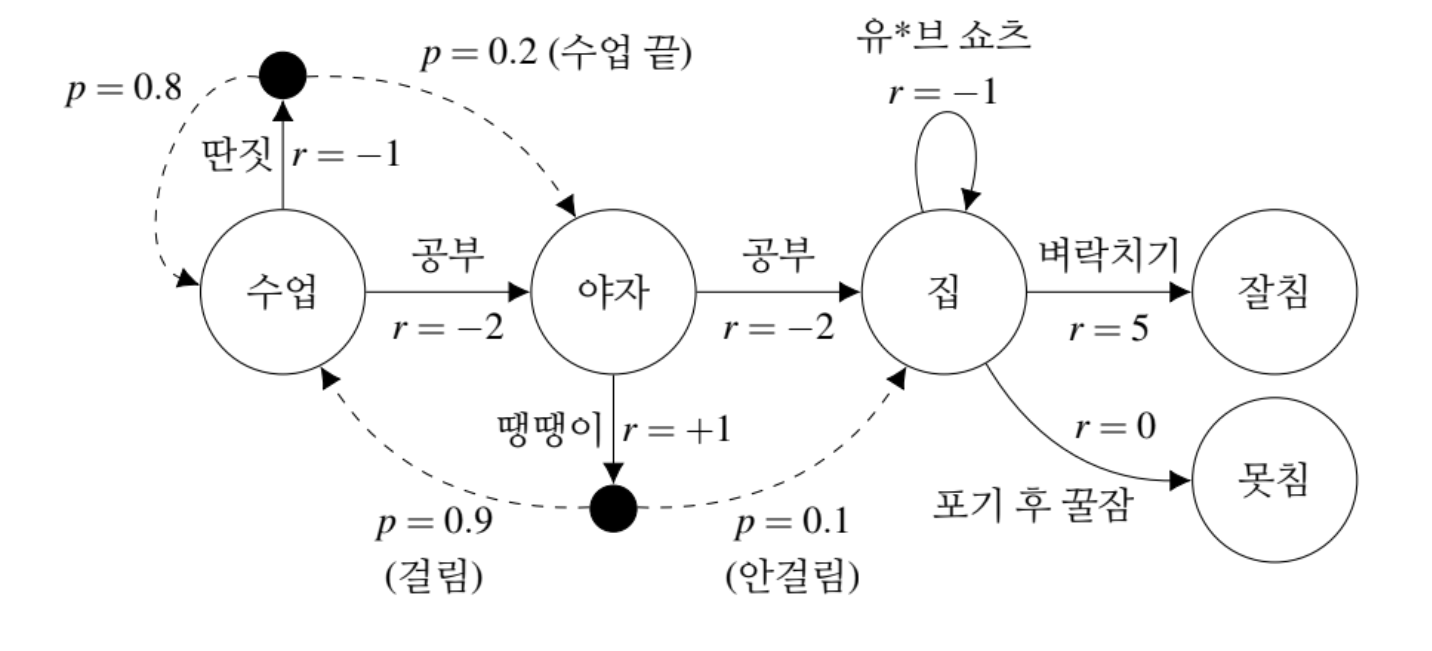

In [105]:
class MyEnv(gym.Env): #환경
    def __init__(self):
        self.observation_space = gym.spaces.Discrete(4, start=0)
        # 0 : 수업
        # 1 : 야자
        # 2 : 집
        # 3 : 시험

        self.action_space = gym.spaces.Discrete(3)


    def reset(self):
        self.state = 0
        return self.state

    def step(self, action):
        q = random.random()
        next_state = self.state
        reward = 0
        done = False

        if self.state == 0: # 수업
            if action == 0: #딴짓
                if q < 0.2:
                    next_state = self.state + 1
                reward = -1
            else: # 공부
                next_state = self.state + 1
                reward = -2

        elif self.state == 1: # 야자
            if action == 0: # 떙땡이
                if q < 0.9:
                    next_state = self.state - 1
                else:
                    next_state = self.state + 1
                reward = 1
            else: # 공부
                next_state = self.state + 1
                reward = -2

        elif self.state == 2: # 집
            if action == 0: # 유튜브
                reward = -1
            elif action == 1: # 벼락치기
                reward = 5
                next_state = self.state + 1
            else: # 잠
                next_state = self.state + 1

        elif self.state == 3: # 시험 결과 나옴
            done = True

        else:
            done = True
            #print("error")

        self.state = next_state  # 다음 상태로 업데이트

        return next_state, reward, done, {}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


i: 0 Total Reward: 0
Training finished.


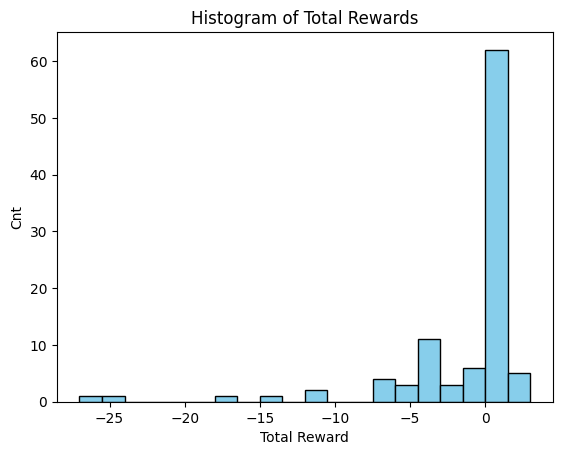

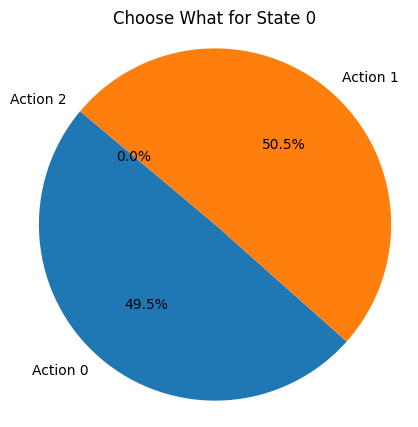

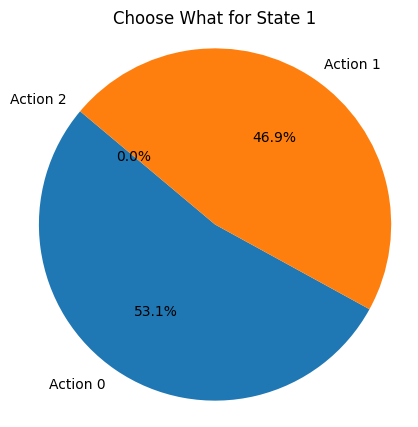

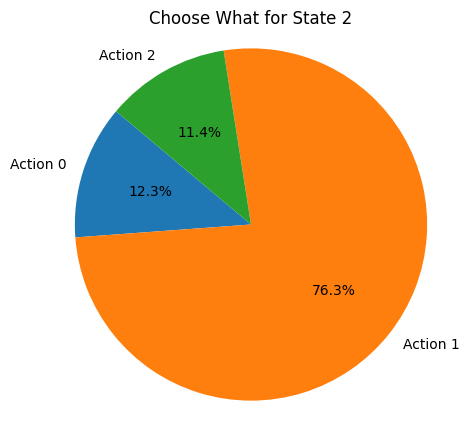

In [126]:
import gym
import random

class Mypolicy():
    def __init__(self, env):
        self.env = env
        self.learning_rate = 0.1 # 학습률
        self.discount_factor = 0.9 # 할인율
        self.exploration_rate = 0.5  # 탐험 확률
        self.exploration_decay = 0.99 # 탐험 확률 조정
        self.min_exploration_rate = 0.01 # 최소 탐험 확률
        self.Q = {}
        self.rewards = []
        self.choose_what = [[0,0,0],[0,0,0],[0,0,0]]
        self.x=0
        self.state = self.env.reset()


        self.Q[(0, 0)] = 0.0
        self.Q[(0, 1)] = 0.0
        self.Q[(1, 0)] = 0.0
        self.Q[(1, 1)] = 0.0
        self.Q[(2, 0)] = 0.0
        self.Q[(2, 1)] = 0.0
        self.Q[(2, 2)] = 0.0

    def choose_action(self):
        if self.state == 3: # state가 3일 때는 의미 없음
            return 0
        elif random.uniform(0, 1) < self.exploration_rate: # 일정 확률로 탐험
            if self.state < 2:
                return random.randint(0, 1)
            else:
                return self.env.action_space.sample()  # 탐험
        else: # 그리디
            if self.state < 2:
                if self.Q[(self.state,0)]>=self.Q[(self.state,1)]:
                    return 0
                else:
                    return 1
            else:
                if self.Q[(self.state,1)]>=self.Q[(self.state,0)] and self.Q[(self.state,1)]>=self.Q[(self.state,2)]:
                    return 1
                elif self.Q[(self.state,0)]>=self.Q[(self.state,1)] and self.Q[(self.state,0)]>=self.Q[(self.state,2)]:
                    return 0
                else:
                    return 2


    def update_Q(self, state, action, next_state, reward):
        current_q_value = self.Q.get((state, action), 0)
        max_future_q_value = max(self.Q.get((next_state, a), 0) for a in range(self.env.action_space.n))
        # 가장 가치가 높은 것을 찾음
        new_q_value = (1 - self.learning_rate) * current_q_value + self.learning_rate * (reward + self.discount_factor * max_future_q_value)
        # 값 업데이트

        self.Q[(state, action)] = new_q_value

    def train(self, training_steps=100):
        for i in range(training_steps):
            self.state = self.env.reset()
            done = False
            total_reward = 0

            while not done:
                action = self.choose_action()
                if self.state != 3:
                    self.choose_what[self.state][action]+=1
                next_state, reward, done, _ = self.env.step(action)
                total_reward += reward

                self.update_Q(self.state, action, next_state, reward)

                self.state = next_state

                if self.state == -1:
                    print("err")

            # 학습률 업데이트
            self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

            self.rewards.append(total_reward)

            if i%50000 == 0:
                print("i:", i, "Total Reward:", total_reward)

        print("Training finished.")

    def plot_choose_what(self):
        for i, row in enumerate(self.choose_what):
            labels = ['Action 0', 'Action 1', 'Action 2']
            plt.figure(figsize=(5, 5))
            plt.pie(row, labels=labels, autopct='%1.1f%%', startangle=140)
            plt.title('Choose What for State {}'.format(i))
            plt.axis('equal')
            plt.show()

# 환경 생성
env = MyEnv()

agent = Mypolicy(env)
agent.train()


plt.hist(agent.rewards, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Reward')
plt.ylabel('Cnt')
plt.title('Histogram of Total Rewards')
# plt.grid(True)
plt.show()

agent.plot_choose_what()

In [127]:
print(agent.choose_what)

[[162, 165, 0], [102, 90, 0], [14, 87, 13]]


In [125]:
print(agent.Q)


{(0, 0): -0.5873879404769156, (0, 1): 0.2401821052741633, (1, 0): 1.5308123850062971, (1, 1): 2.497288565679354, (2, 0): 1.318952829790585, (2, 1): 4.999691481740415, (2, 2): 0.0, (3, 0): 0.0}
